<img src="images/buildacourt.jpg" alt="Drawing" style="width: 438px;"/><img src="images/luxurycourt.jpg" alt="Drawing" style="width: 492px;"/>

## Step 4 - Building a Model - ATP Match Statistics

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

# Set standard figure size for plots
mlp.rcParams['figure.figsize'] = (10,6)

# Set Seaborn Styles
sns.set()

# Set Color Palette that can be used for plotting
colorsP = ['#D28DDC','#CA7AD6','#C366D0','#BB53CA','#B340C3','#A337B2','#A437B3','#92319F','#802B8C','#6E2578']
colorsP = colorsP[::-1]

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



In [2]:
dflog = pd.read_csv('data/results.csv')
dflog = dflog.drop(['Unnamed: 0'], axis = 1)
dflogtrain = pd.read_csv('data/test.csv')
dflogtrain = dflogtrain.drop(['Unnamed: 0'], axis = 1)
dflogtest = pd.read_csv('data/test.csv')
dflogtest = dflogtest.drop(['Unnamed: 0'], axis = 1)

In [3]:
features = ['aces','ace_pct','double_faults','df_pct','first_serves_in','srv_pts_pct','first_serve_points_won',
            'return_points_won','rtn_pts_pct','break_points_converted','brk_pts_pct','total_points_won','points_won_pct']
features1 = ['rank_dif','aces','double_faults','first_serves_in', 'first_serve_points_won','second_serve_points_won',
            'break_points_saved','service_points_won','first_serve_return_won','second_serve_return_won',
            'break_points_converted','service_games_played','return_games_played','return_points_won',
            'total_points_won','games_won','ace_pct','df_pct','srv_pts_pct','rtn_pts_pct','brk_pts_pct','points_won_pct']
predictor = ['win']

In [4]:
data = pd.DataFrame(dflog[features])

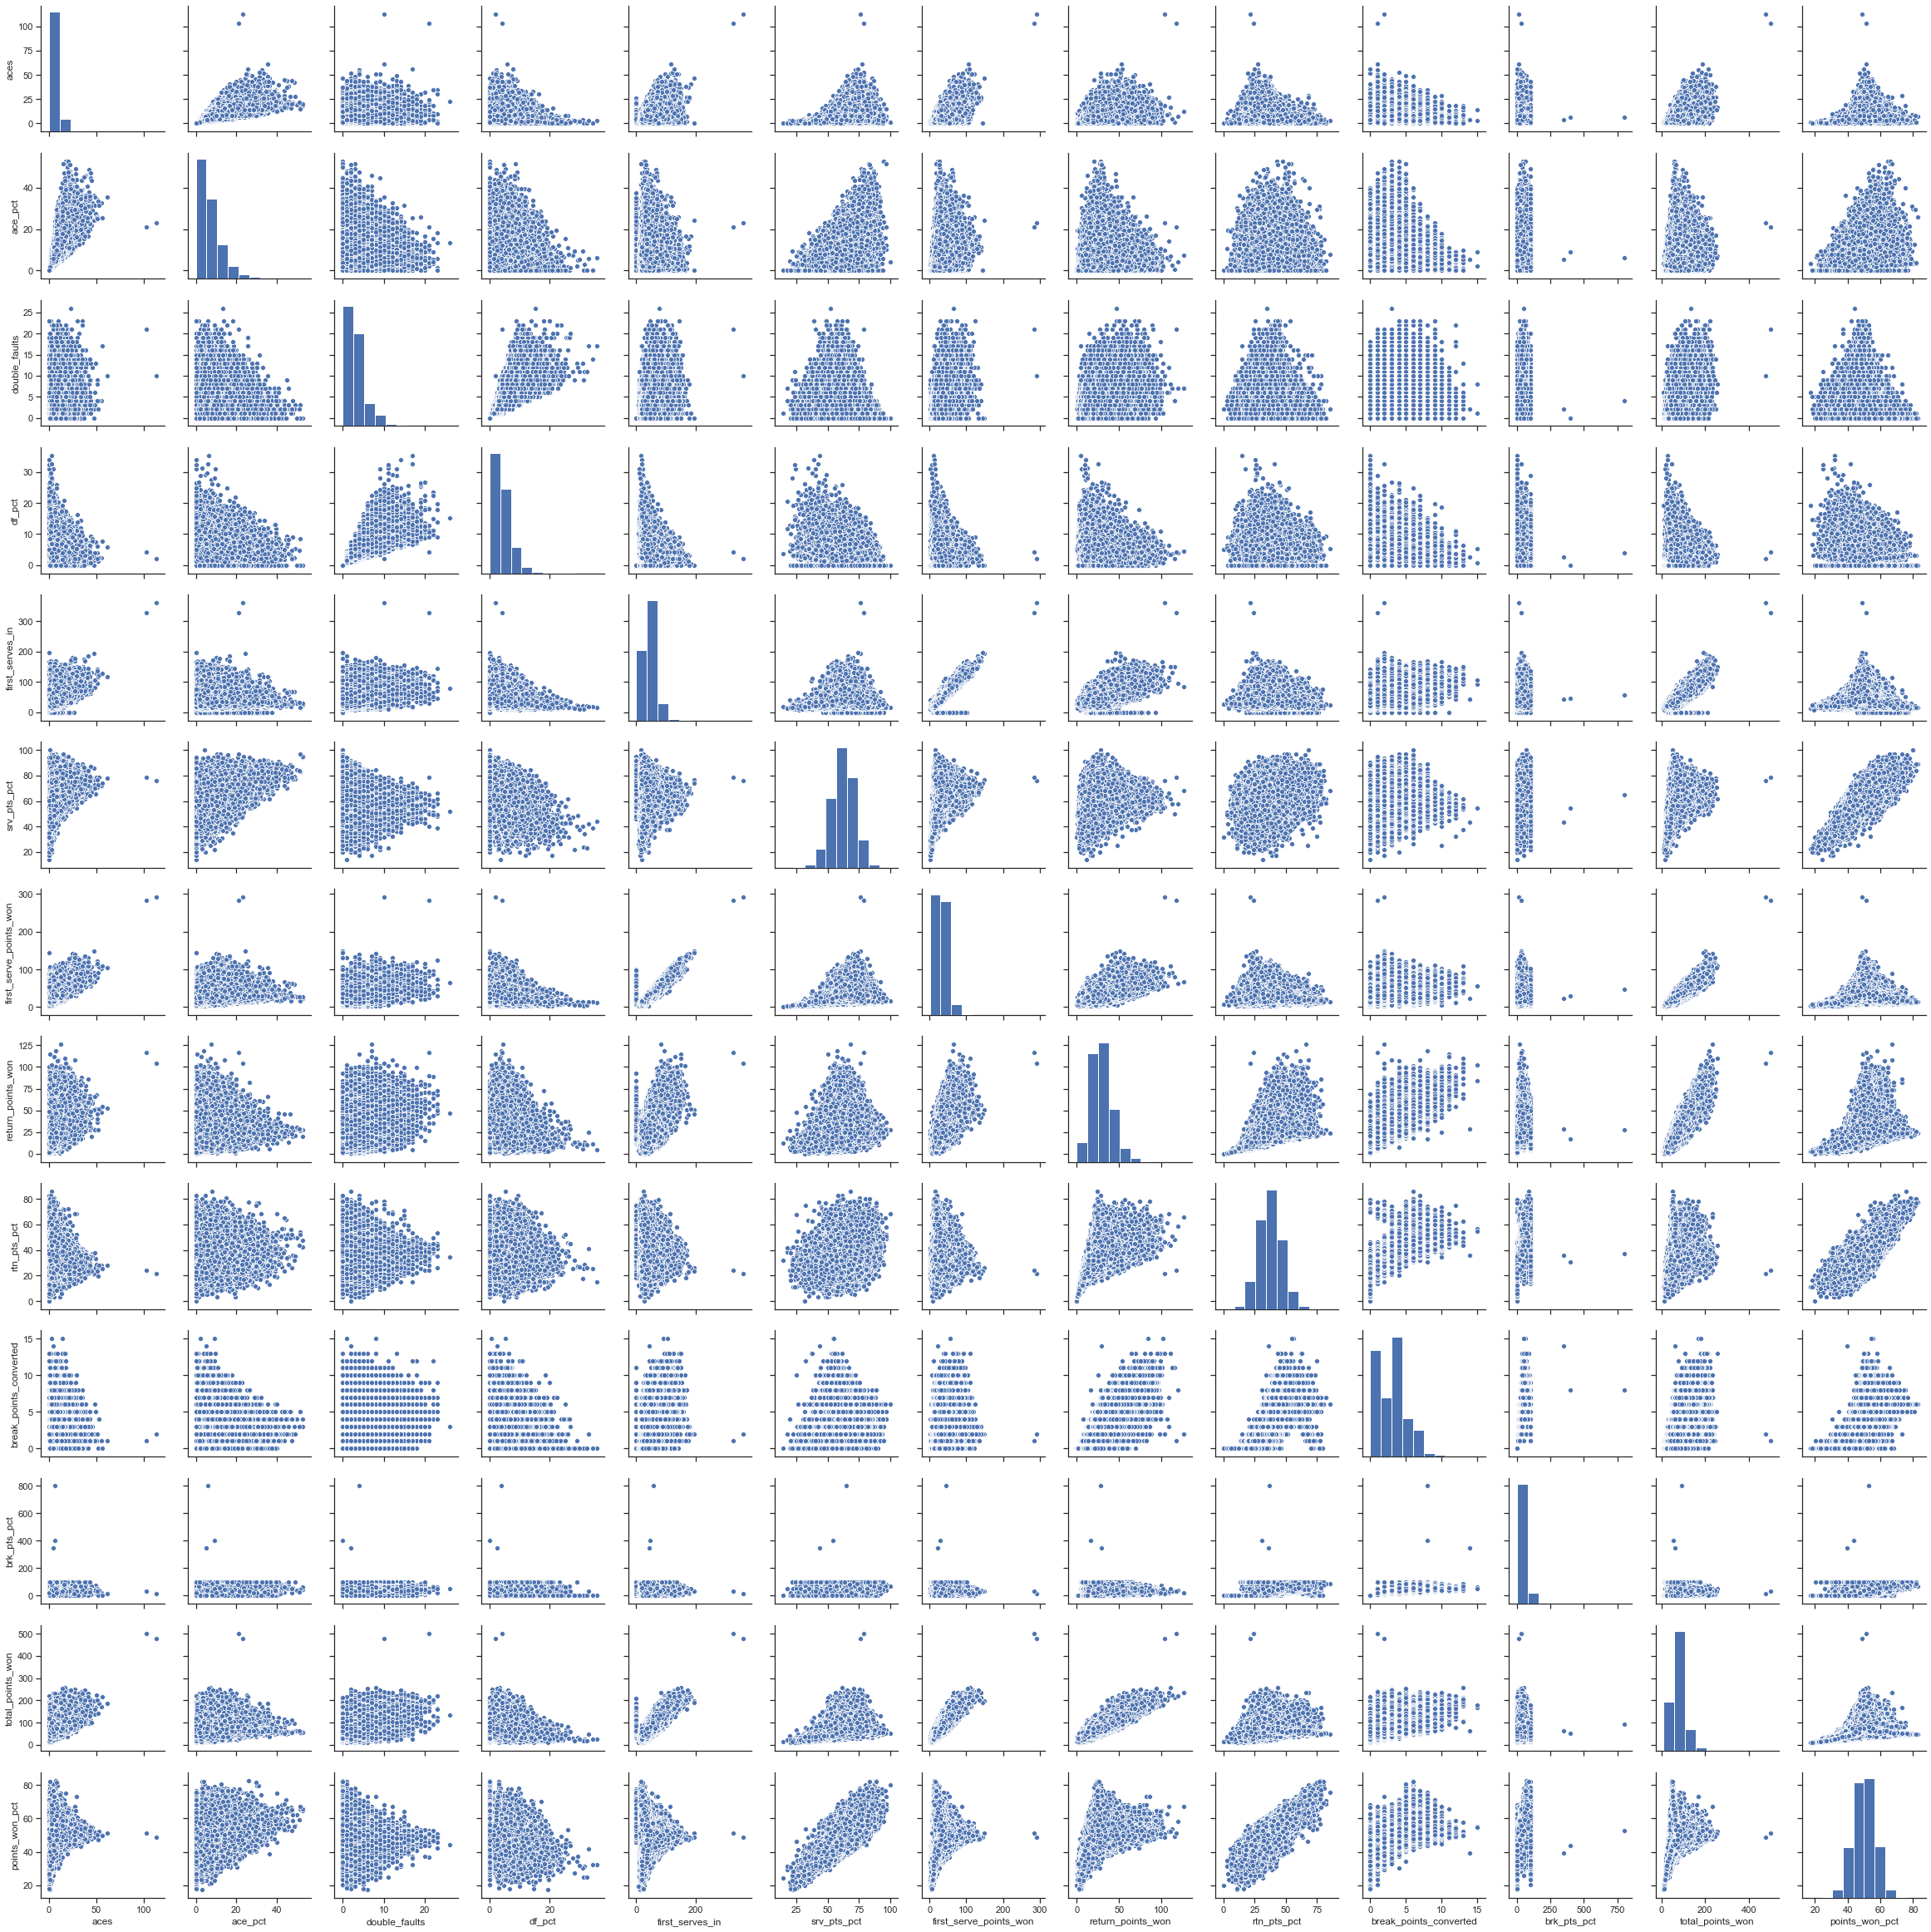

In [5]:
# sns.pairplot(data c=[cm_bright.colors[i] for i in dflog.win==1], alpha=0.08);

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data)
plt.show()


In [6]:
from sklearn.model_selection import train_test_split

# Split Training Data in Holdout Set and Training and Test Data sets
Xy_train = dflog.loc[:,features + predictor].dropna()
X = Xy_train.drop('win',axis=1)
y = Xy_train['win']

X_tune, X_hold, y_tune, y_hold = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_tune, y_tune, test_size=0.2, random_state=42)

In [7]:
from sklearn.preprocessing import StandardScaler

def scale_data(X_train,X_test):
    # scaling data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, scaler

# Get Scaled Training and Test Features
X_train, X_test, scaler = scale_data(X_train, X_test)

LR Scores:  [0.99058782 0.98977854 0.99161142 0.99047715 0.991238  ]
Mean ROC AUC Score: 0.9907385871133079
LR Score Range: 0.0018


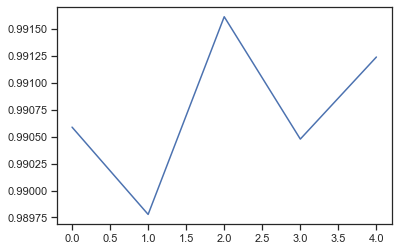

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

def run_lr(X_train,y_train):
    """
    Run a Logistic Recression of Features and Target Variable. We're using ROC AUC Score with Cross Validation
    """
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    lr = LogisticRegression()
    
    lr_scores = cross_val_score(lr,
                                X_train,
                                y_train,
                                cv=5,
                                scoring='roc_auc')
    
    print('LR Scores: ', lr_scores)
    print('Mean ROC AUC Score: {}'.format(lr_scores.mean()))
    print('LR Score Range: {}'.format(round(lr_scores.max() - lr_scores.min(),4)))
    _ = plt.plot(np.arange(len(lr_scores)),lr_scores)

    return lr

lr = run_lr(X_train,y_train)

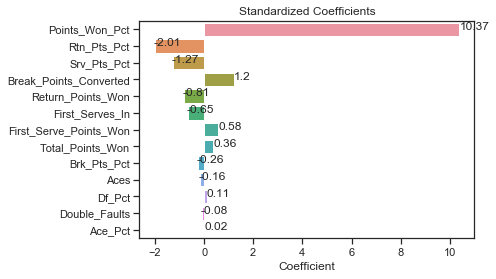

In [10]:
def plot_coef(X,y,features):
    """
    Plot the Beta values of a Logistic Regression based on the Features and Target Variable provided.
    """
    lr = LogisticRegression()
    std_scaler = StandardScaler()
    X_train_std = std_scaler.fit_transform(X_train)
    lr.fit(X_train,y_train)
    std_coef = lr.coef_.reshape(-1,1).tolist()
    feature_names = [feature.title() for feature in features]
    coef_df = pd.DataFrame(std_coef,index=feature_names,columns=['coef'])
    coef_df['abs'] = coef_df['coef'].abs()
    coef_df = coef_df.sort_values(by='abs',ascending=False).drop('abs',axis=1)
    ax = sns.barplot(coef_df['coef'],coef_df.index)
    for i, row in enumerate(coef_df.iterrows()):
        row_values = row[1]
        if row_values.coef < 0:
            ax.text(row_values.coef - 0.05,i,round(row_values.coef,2))
        else:
            ax.text(row_values.coef + 0.01,i,round(row_values.coef,2))
    _ = plt.xlabel('Coefficient')
    _ = plt.title('Standardized Coefficients')


plot_coef(X_train,y_train,features)

In [11]:
# Remove more features
X_tune_skim = X_tune.drop(['ace_pct','double_faults','df_pct','aces','brk_pts_pct','total_points_won'],axis=1)
X_tune_skim.head()

,first_serves_in,srv_pts_pct,first_serve_points_won,return_points_won,rtn_pts_pct,break_points_converted,points_won_pct
123400,67.0,66.929134,55.0,54.0,39.416058,7.0,52.651515
81488,70.0,68.367347,50.0,42.0,37.168142,3.0,51.658768
147106,55.0,53.333333,31.0,38.0,54.285714,7.0,53.793103
88849,50.0,58.666667,31.0,24.0,32.876712,2.0,45.945946
153391,67.0,52.873563,35.0,36.0,42.352941,4.0,47.674419


In [12]:
# Concatenate Target Variables and Predictor Variables
tune = pd.concat([X_tune_skim,y_tune.astype(int)],axis=1)
tune.head()

,first_serves_in,srv_pts_pct,first_serve_points_won,return_points_won,rtn_pts_pct,break_points_converted,points_won_pct,win
123400,67.0,66.929134,55.0,54.0,39.416058,7.0,52.651515,1
81488,70.0,68.367347,50.0,42.0,37.168142,3.0,51.658768,1
147106,55.0,53.333333,31.0,38.0,54.285714,7.0,53.793103,1
88849,50.0,58.666667,31.0,24.0,32.876712,2.0,45.945946,0
153391,67.0,52.873563,35.0,36.0,42.352941,4.0,47.674419,0


In [13]:
# find correlations to target
corr_matrix = X_tune_skim.corr().abs()

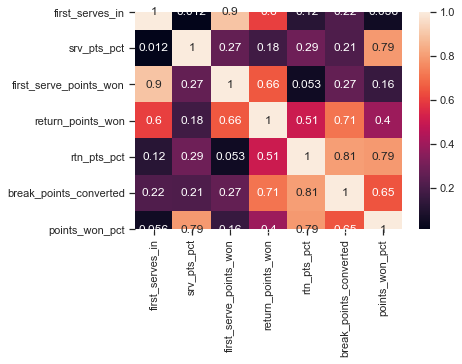

In [14]:
# Plot correlations for Tuning variables
sns.heatmap(corr_matrix,annot=True)
plt.show;

In [15]:
corr_matrix.break_points_converted[:]

first_serves_in           0.220365
srv_pts_pct               0.214534
first_serve_points_won    0.266897
return_points_won         0.711933
rtn_pts_pct               0.805197
break_points_converted    1.000000
points_won_pct            0.645552
Name: break_points_converted, dtype: float64

In [16]:
# Remove more features
tune_clean = tune.drop([],axis=1)

LR Scores:  [0.99045933 0.98962495 0.99154754 0.99035066 0.99113649]
Mean ROC AUC Score: 0.9906237927796265
LR Score Range: 0.0019


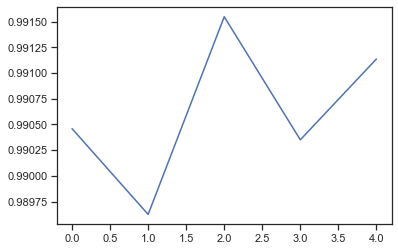

In [17]:
X_tune_cl = tune_clean.drop('win', axis=1)
y_tune_cl = tune_clean['win']

# Split cleaned tuning data again
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_tune_cl, y_tune_cl, test_size=0.2, random_state=42)
X_train_sc, X_test_sc, scaler_sc = scale_data(X_train_cl,X_test_cl)

# Test Improvements in Logistic Regression
lr = run_lr(X_train_sc,y_train_cl)

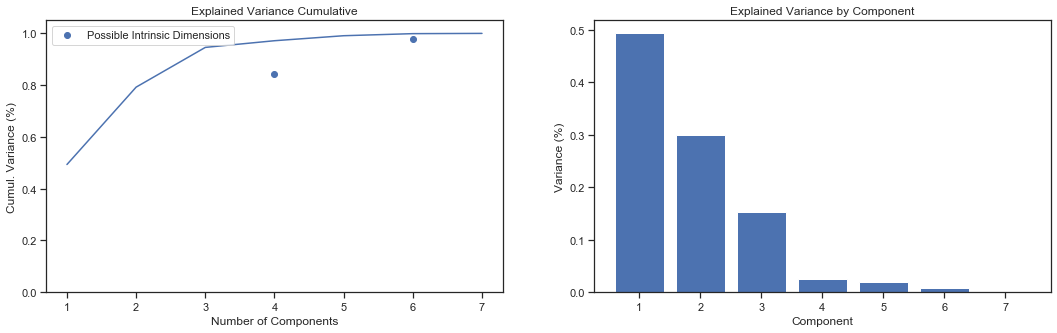

In [18]:
from sklearn.decomposition import PCA

#Fitting the PCA algorithm with our Data
pca = PCA()
pca.fit(X_train_sc)

#Plotting the Cumulative Summation of the Explained Variance
fig, ax = plt.subplots(1,2,figsize=(18,5))

plt.subplot(1,2,1)
explained_var_ratio = pca.explained_variance_ratio_
explained_cum_var = np.cumsum(explained_var_ratio)
_ = plt.plot(explained_cum_var)
_ = plt.xticks(np.arange(0,len(explained_cum_var)),np.arange(1,len(explained_cum_var) + 1) )
_ = plt.xlabel('Number of Components')
_ = plt.ylabel('Cumul. Variance (%)') #for each component
_ = plt.ylim(0,1+0.05)
_ = plt.title('Explained Variance Cumulative')
_ = plt.scatter([5,3],[0.98,0.845],label='Possible Intrinsic Dimensions')
_ = plt.legend(loc='upper left')

plt.subplot(1,2,2)
_ = plt.bar(np.arange(1, len(explained_var_ratio) + 1),explained_var_ratio)
_ = plt.xlabel('Component')
_ = plt.ylabel('Variance (%)') #for each component
_ = plt.title('Explained Variance by Component')

In [19]:
# Conduct the PCA with 4 components
pca4 = PCA(n_components=4)
X_train_reduced = pca4.fit_transform(X_train_sc)
X_test_reduced = pca4.transform(X_test_sc)

LR Scores:  [0.98868845 0.98813204 0.98992767 0.98898823 0.98974377]
Mean ROC AUC Score: 0.9890960306713623
LR Score Range: 0.0018


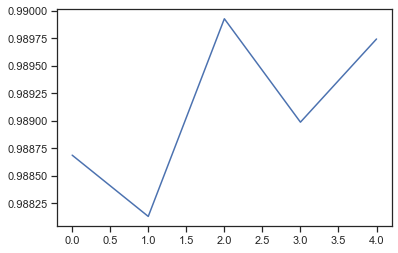

In [20]:
lr = run_lr(X_train_reduced,y_train_cl)

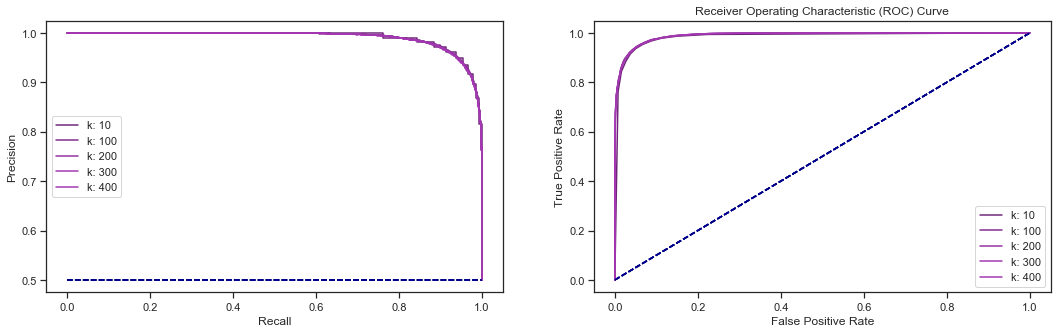

<Figure size 1296x576 with 0 Axes>

Max Precision-Recall AUC: 0.9897802251819037 at 200 neighbors
Max ROC AUC: 0.9896496139482173 at 200 neighbors


In [22]:
from sklearn.neighbors import KNeighborsClassifier

# Set Neighbors for plotting curves
neighbors = np.arange(0,500,100)
neighbors[0] = 10
pr_aucs = np.empty(len(neighbors))
roc_aucs = np.empty(len(neighbors))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,5))

fig = plt.figure(figsize=(18,8))

for i,k in enumerate(neighbors):
    """
    Iterate of the estimators and plot PR curves as well as ROC curves
    """
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_reduced,y_train_cl)

    y_test_pred = knn.predict_proba(X_test_reduced).T[1]
    pr_auc = plot_pr_curve(y_test_cl,y_test_pred,k,colorsP[i],ax=ax1)
    roc_auc = plot_roc_curve(y_test_cl,y_test_pred,k,colorsP[i],ax=ax2)
    pr_aucs[i] = pr_auc
    roc_aucs[i] = roc_auc
    
_ = plt.tight_layout()

plt.show()

best_pr = pr_aucs.max()
best_pr_k = neighbors[np.where(pr_aucs == best_pr)[0]][0]
best_roc_auc = roc_aucs.max()
best_roc_auc_k = neighbors[np.where(roc_aucs == best_roc_auc)[0]][0]

print("Max Precision-Recall AUC: {} at {} neighbors".format(best_pr,best_pr_k))
print("Max ROC AUC: {} at {} neighbors".format(best_roc_auc,best_roc_auc_k))

In [23]:
# Create RandomForest Classifier with Best Precision Recall Hyperparameter
rf_best = RandomForestClassifier(n_estimators=best_pr_k,random_state=42)
_ = rf_best.fit(X_train_reduced,y_train_cl)

In [24]:
from sklearn.pipeline import make_pipeline

# Create A Pipeline for the Best RandomForest Classifier
pipeline_rf = make_pipeline(StandardScaler(), PCA(n_components=4), RandomForestClassifier(n_estimators=best_pr_k, random_state=42))
rf_best = pipeline_rf.fit(X_train_cl,y_train_cl)

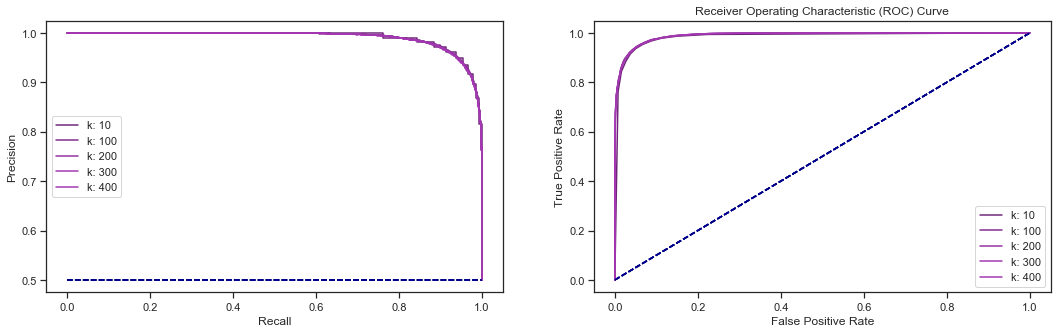

<Figure size 1296x576 with 0 Axes>

Max Precision-Recall AUC: 0.9897802251819037 at 200 neighbors
Max ROC AUC: 0.9896496139482173 at 200 neighbors


In [25]:
from sklearn.neighbors import KNeighborsClassifier

# Set Neighbors for plotting curves
neighbors = np.arange(0,500,100)
neighbors[0] = 10
pr_aucs = np.empty(len(neighbors))
roc_aucs = np.empty(len(neighbors))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,5))

fig = plt.figure(figsize=(18,8))

for i,k in enumerate(neighbors):
    """
    Iterate of the estimators and plot PR curves as well as ROC curves
    """
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_reduced,y_train_cl)

    y_test_pred = knn.predict_proba(X_test_reduced).T[1]
    pr_auc = plot_pr_curve(y_test_cl,y_test_pred,k,colorsP[i],ax=ax1)
    roc_auc = plot_roc_curve(y_test_cl,y_test_pred,k,colorsP[i],ax=ax2)
    pr_aucs[i] = pr_auc
    roc_aucs[i] = roc_auc
    
_ = plt.tight_layout()

plt.show()

best_pr = pr_aucs.max()
best_pr_k = neighbors[np.where(pr_aucs == best_pr)[0]][0]
best_roc_auc = roc_aucs.max()
best_roc_auc_k = neighbors[np.where(roc_aucs == best_roc_auc)[0]][0]

print("Max Precision-Recall AUC: {} at {} neighbors".format(best_pr,best_pr_k))
print("Max ROC AUC: {} at {} neighbors".format(best_roc_auc,best_roc_auc_k))

In [26]:
# Create kNN Classifier with Best Precision Recall Hyperparameter
knn_best = KNeighborsClassifier(n_neighbors=best_pr_k)
knn_best.fit(X_train_cl,y_train_cl)

# Create Pipeline with kNN Classifier
pipeline_knn = make_pipeline(StandardScaler(), PCA(n_components=4), KNeighborsClassifier(n_neighbors=best_pr_k))
knn_best = pipeline_knn.fit(X_train_cl,y_train_cl)

In [27]:
from sklearn.metrics import log_loss,accuracy_score, precision_recall_fscore_support

def get_eval(clf,X,y_true):
    """
    Creates metrics for the Classifier using Precision, Recall, F1-Score and Accuracy as well as Logloss
    """
    y_pred = clf.predict(X)
    accuracy = (np.nan,accuracy_score(y_true,y_pred))

    y_pred_proba = clf.predict_proba(X)
    logloss = (np.nan,log_loss(y_true,y_pred_proba))
    
    # Beta shifts the weight toward recall by a factor of beta (e.g. beta=0.5 -> recall is half as important as precision)
    beta = 1
    precision, recall, f1, support = precision_recall_fscore_support(y_true,y_pred,beta=beta)

    scores = ['accuracy','logloss','precision','recall','f1 beta={}'.format(beta),'support']
    labels = list(clf.classes_)
    display(pd.DataFrame([accuracy,logloss,precision,recall,f1,support],columns=labels,index=scores))

get_eval(pipeline_rf,X_test_cl,y_test_cl)

,0,1
accuracy,NaN,0.944111
logloss,NaN,0.148314
precision,0.947327,0.940945
recall,0.940471,0.947749
f1 beta=1,0.943887,0.944335
support,14094.000000,14105.000000


In [28]:
get_eval(pipeline_knn,X_test_cl,y_test_cl)

,0,1
accuracy,NaN,0.945565
logloss,NaN,0.142949
precision,0.950111,0.941115
recall,0.940471,0.950656
f1 beta=1,0.945267,0.945861
support,14094.000000,14105.000000


In [29]:
# Prepare the Hold out data set
X_hold_skim = X_hold.drop(['ace_pct','double_faults','df_pct','aces','brk_pts_pct','total_points_won'],axis=1)
hold = pd.concat([X_hold_skim,y_hold.astype(int)],axis=1)
hold_clean = hold.drop([],axis=1)
X_hold_cl = hold_clean.drop('win', axis=1)
y_hold_cl = hold_clean['win'].astype(bool)

In [30]:
get_eval(pipeline_rf, X_hold_cl, y_hold_cl)

,0,1
accuracy,NaN,0.943034
logloss,NaN,0.152072
precision,0.943847,0.942235
recall,0.941368,0.944679
f1 beta=1,0.942606,0.943456
support,17516.000000,17733.000000


In [31]:
get_eval(pipeline_knn, X_hold_cl, y_hold_cl)

,0,1
accuracy,NaN,0.945162
logloss,NaN,0.143528
precision,0.947248,0.943123
recall,0.942110,0.948176
f1 beta=1,0.944672,0.945643
support,17516.000000,17733.000000


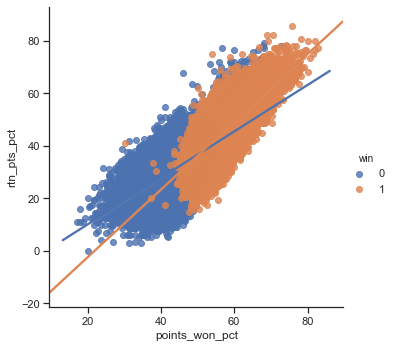

In [33]:
sns.lmplot(data=dflog,x="points_won_pct",y="rtn_pts_pct",hue="win")
plt.show()